In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time
from scipy.spatial.distance import cdist
import pandas as pd

#### Генерация данных

In [ ]:
def dim_spirals(n, d, std_dev=0):
    t = np.linspace(0, 4 * np.pi, n)
    
    x = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            x.append(t * np.cos(t * i / 2) + cos_noise)
            x.append(t * np.sin(t * i / 2) + sin_noise)
        else:
            x.append(t * np.cos(t * i / 2))
            x.append(t * np.sin(t * i / 2))
    x = np.array(x).T
    # print(f'x shape: {x.shape}')
    labels_x = ['A'] * n
    
    y = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            y.append(t * np.cos(t * i / 2 + np.pi) + cos_noise)
            y.append(t * np.sin(t * i / 2 + np.pi) + sin_noise)
        else:
            y.append(t * np.cos(t * i / 2 + np.pi))
            y.append(t * np.sin(t * i / 2 + np.pi))
    y = np.array(y).T
    labels_y = ['B'] * n
    
    points = np.vstack((x, y))
    labels = labels_x + labels_y
    
    if d == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(points[:n, 0], points[:n, 1], c='red', label='A')
        plt.scatter(points[n:, 0], points[n:, 1], c='blue', label='B')
        plt.title("Spiral Data Visualization (d=2)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()
    
    return points, labels

#### Обучение деревьев

In [5]:
def fitted_extrees(train_points: np.ndarray, train_labels: np.ndarray, n_estimators: int, random_state: int = 42, max_depth: int | None = None):
    extrees = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)
    extrees.fit(train_points, train_labels)
    return extrees

#### Перевод в бинарный путь и функция расстояния

In [6]:
def trace_binary_path_opt(tree, sample_leaf_index):
    children_left = tree.children_left
    children_right = tree.children_right
    search = sample_leaf_index
    binary_path = []
    while True:
        i = np.where(children_left == search)[0]
        if i.size:
            binary_path.append(0) 
        else:
            i = np.where(children_right == search)[0]
            binary_path.append(1) 
        i = i[0]
        if i == 0:
            break
        search = i
    return np.array(binary_path[::-1], dtype=int)

def padded_dist(x: np.ndarray, y: np.ndarray):
    diff_idx = np.where(x != y)[0]
    if diff_idx.size > 0:
        return len(x) - diff_idx[0]
    return 0

#### Попарные расстояния

In [7]:
def extrees_train_and_cdist_pairwise_dists(extrees: ExtraTreesClassifier, points: np.ndarray, train_idx: np.ndarray):
    n_points = points.shape[0]
    n_trees = len(extrees.estimators_)
    n_train_idx = len(train_idx)
    leaf_indices = np.array([tree.apply(points) for tree in extrees.estimators_])  # Shape: (n_trees, n_points)

    def pad_binary_paths(tree_paths):
        max_length = max(len(path) for path in tree_paths)
        return np.array([np.pad(path, (0, max_length - len(path)), 'constant') for path in tree_paths])
    padded_binary_paths = [
        pad_binary_paths([trace_binary_path_opt(tree.tree_, leaf_indices[k, pind]) for pind in range(n_points)])
        for k, tree in enumerate(extrees.estimators_)
    ]
    pairwise_distances = np.zeros((n_points, n_train_idx))
    for t in range(n_trees):
        tree_paths = padded_binary_paths[t]
        dist_matrix = cdist(tree_paths, tree_paths[train_idx], metric=padded_dist)
        pairwise_distances += dist_matrix
    pairwise_distances /= n_trees
    return pairwise_distances

#### Функции для смешанного расстояния и ядерной регрессии

In [8]:
def gaussian_dist_flat(points_target, points_other):
    diff = points_target[:, None, :] - points_other[None, :, :]
    # Shape: (n_target_points, n_other_points, n_features)
    return np.sum(diff ** 2, axis=-1)
    # Shape: (n_target_points, n_other_points)

def mixed_kernel_dist_predictions(target_indices, points, labels, train_idx, pairwise_distances, bandwidth=0.5, alpha=0.5):
    beta = 1 - alpha
    points_target = points[target_indices]
    points_train = points[train_idx]
    pairwise_dists_subset = pairwise_distances[target_indices]
    flat_dists = gaussian_dist_flat(points_target, points_train)
    combined_dists = alpha * flat_dists + beta * pairwise_dists_subset
    
    weights = np.exp(-(combined_dists / (2 * bandwidth ** 2)))
    weights /= np.sum(weights, axis=1, keepdims=True)
    train_labels = labels[train_idx]
    predictions = np.dot(weights, train_labels)
    return predictions

def predictions_from_flat_and_pairdist_mix(target_indices, train_idx, labels, flat_dists, pair_dists, bandwidth, alpha):
    beta = 1 - alpha
    pairwise_dists_subset = pair_dists[target_indices]
    combined_dists = alpha * flat_dists + beta * pairwise_dists_subset
    weights = np.exp(-(combined_dists / (2 * bandwidth ** 2)))
    weights /= np.sum(weights, axis=1, keepdims=True)
    train_labels = labels[train_idx]
    predictions = np.dot(weights, train_labels)
    return predictions

### Сравнения методов: метрики, смешанного расстояния, ExtraTrees и KNN

In [ ]:
def compare_metric_mix_plain_et_knn(n_estimators=10, num_neighbors=1, test_size=0.8, times = 10, N = 500, DIM = 8, bandwidth=1):
    seeds = []
    metric_res = []
    mix_res = []
    et_res = []
    knn_res = []
    for iter_i in range(times):
        # print(f'iter = {iter_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels = dim_spirals(N, DIM, std_dev=0.5)
        labels = np.array(labels)
        train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        pair_dists = extrees_train_and_cdist_pairwise_dists(extrees, points, train_idx)
        train_distances = pair_dists[train_idx]
        test_distances = pair_dists[test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        knn.fit(train_distances, train_labels)
        predicted_labels = knn.predict(test_distances)
        accuracy = accuracy_score(test_labels, predicted_labels)
        metric_res.append(accuracy)
        
        int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        int_test_labels = int_labels[test_idx]
        mix_pred = mixed_kernel_dist_predictions(test_idx, points, int_labels, train_idx, pair_dists, bandwidth)
        pred_labels = (mix_pred >= 0.5).astype(int)
        accuracy = accuracy_score(int_test_labels, pred_labels)
        mix_res.append(accuracy)
        
        et_predicted = extrees.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, et_predicted)
        et_res.append(accuracy)

        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(points[train_idx], train_labels)
        knn_pred = knn.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, knn_pred)
        knn_res.append(accuracy)
    return np.array(seeds), np.array(metric_res), np.array(mix_res), np.array(et_res), np.array(knn_res)

In [10]:
n_estimators = 10
test_size = 0.8
times = 20
seeds, metric_res, mix_res, et_res, knn_res = compare_metric_mix_plain_et_knn(n_estimators=n_estimators, test_size=test_size, times=times)
print(f'Metric avg: {np.average(metric_res)}')
print(f'Kernel mix avg: {np.average(mix_res)}')
print(f'ExtraTrees avg: {np.average(et_res)}')
print(f'KNN avg: {np.average(knn_res)}')

Metric avg: 0.9370625
Kernel mix avg: 0.9780624999999998
ExtraTrees avg: 0.904625
KNN avg: 0.9750625000000002


In [11]:
accuracies = pd.DataFrame(
    {
        'Seed': seeds,
        'Metric': metric_res,
        'KernelMix': mix_res,
        'ExtraTrees': et_res,
        'KNN': knn_res
    }
)
print(accuracies.head())
accuracies.to_csv(f'accuracies_{time.time_ns()}_nest{n_estimators}_ts{test_size}_t{times}.csv')

         Seed   Metric  KernelMix  ExtraTrees      KNN
0   973771904  0.94875    0.98125     0.91625  0.98250
1   291963416  0.93875    0.97500     0.89500  0.96500
2  3859692620  0.90500    0.98000     0.86750  0.97625
3  3801854528  0.93625    0.98000     0.92250  0.97500
4  2048553440  0.94750    0.97500     0.92000  0.97875


### Усреднения точности в смешанном расстоянии для разных значений alpha (Параметр смешивания ЯР и метрики)

In [12]:
def test_mix_alpha_values(n_estimators=10, bandwidth=0.5, test_size=0.8, times=10, N=500, DIM=8):
    alphas = np.arange(0, 1.1, 0.1)
    results = {alpha: np.zeros(times) for alpha in alphas}
    seeds = []
    for it_i in range(times):
        # print(f'iter = {it_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels = dim_spirals(N, DIM, std_dev=1)
        labels = np.array(labels)
        int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=random_state)
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        pair_dists = extrees_train_and_cdist_pairwise_dists(extrees, points, train_idx)
        train_labels = labels[train_idx]
        test_labels = int_labels[test_idx]
        flat_dists = gaussian_dist_flat(points[test_idx], points[train_idx])
        for alpha_ in results:
            mix_pred = predictions_from_flat_and_pairdist_mix(test_idx, train_idx, int_labels, flat_dists, pair_dists, bandwidth, alpha_)
            pred_labels = (mix_pred >= 0.5).astype(int)
            results[alpha_][it_i] = accuracy_score(test_labels, pred_labels)
    return seeds, results

In [13]:
times = 30
test_size = 0.8
n_estimators = 20
seeds, results = test_mix_alpha_values(n_estimators=n_estimators, test_size=test_size, times=times)

In [14]:
alphas = pd.DataFrame(results)
alphas['Seed'] = seeds
print(alphas.head())
alphas.to_csv(f'alphas_{time.time_ns()}_t{times}_ts{test_size}_est{n_estimators}.csv')

       0.0      0.1      0.2      0.3      0.4      0.5      0.6      0.7  \
0  0.91875  0.93250  0.93625  0.93625  0.93875  0.93875  0.94000  0.93875   
1  0.89875  0.92125  0.91750  0.92250  0.92125  0.92375  0.92500  0.92500   
2  0.90750  0.93625  0.93375  0.93625  0.94000  0.93500  0.93500  0.93125   
3  0.91250  0.92750  0.93000  0.93125  0.93500  0.93500  0.93375  0.93375   
4  0.92125  0.93250  0.93625  0.93750  0.93750  0.93750  0.93375  0.93500   

       0.8      0.9      1.0        Seed  
0  0.93875  0.93875  0.93875  1130993848  
1  0.92625  0.92375  0.92250    17923568  
2  0.93000  0.92875  0.92875  2685011480  
3  0.93250  0.93250  0.93375   726613596  
4  0.93500  0.93500  0.93750   861113212  


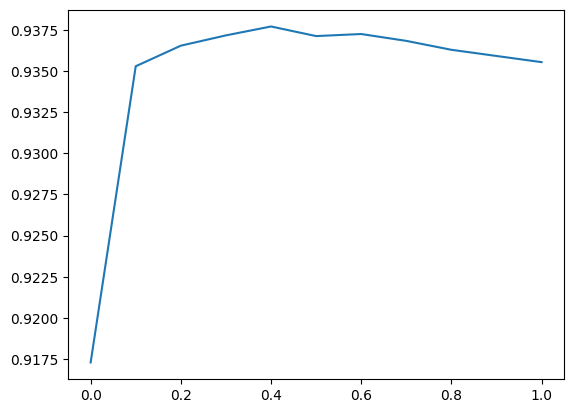

In [15]:
means = alphas.mean().drop('Seed')
# print(means)
plt.plot(means)

In [16]:
print(means.idxmax())

0.4


In [17]:
print(means)

0.0    0.917292
0.1    0.935292
0.2    0.936542
0.3    0.937167
0.4    0.937708
0.5    0.937125
0.6    0.937250
0.7    0.936833
0.8    0.936292
0.9    0.935917
1.0    0.935542
dtype: float64


### Спирали с шумными признаками

In [87]:
def dim_spirals_noisy_features(n, d, n_noisy = 4, std_dev=0):
    t = np.linspace(0, 4 * np.pi, n)
    noise_scale = 1
    x = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            x.append(t * np.cos(t * i / 2) + cos_noise)
            x.append(t * np.sin(t * i / 2) + sin_noise)
        else:
            x.append(t * np.cos(t * i / 2))
            x.append(t * np.sin(t * i / 2))
    for i in range(n_noisy):
        x.append(np.random.normal(0, noise_scale * std_dev, n))
    x = np.array(x).T
    # print(f'x shape: {x.shape}')
    labels_x = ['A'] * n
    
    y = []
    for i in range(2, d + 1, 2):
        if std_dev != 0:
            cos_noise = np.random.normal(0, std_dev, n)
            sin_noise = np.random.normal(0, std_dev, n)
            y.append(t * np.cos(t * i / 2 + np.pi) + cos_noise)
            y.append(t * np.sin(t * i / 2 + np.pi) + sin_noise)
        else:
            y.append(t * np.cos(t * i / 2 + np.pi))
            y.append(t * np.sin(t * i / 2 + np.pi))
    for i in range(n_noisy):
        y.append(np.random.normal(0, noise_scale * std_dev, n))
    y = np.array(y).T
    labels_y = ['B'] * n
    
    points = np.vstack((x, y))
    labels = labels_x + labels_y
    return points, labels

#### Сравнение

In [88]:
def compare_metric_mix_plain_et_knn_noisy_features(n_estimators=10, num_neighbors=1, test_size=0.8, times = 10, N = 500, DIM = 8, bandwidth=1, std_dev=0.5):
    seeds = []
    metric_res = []
    mix_res = []
    et_res = []
    knn_res = []
    for iter_i in range(times):
        # print(f'iter = {iter_i}')
        seed = time.time_ns() % (2 ** 32)
        seeds.append(seed)
        np.random.seed(seed)
        random_state = seed
        points, labels = dim_spirals_noisy_features(N, 2, DIM, std_dev=std_dev)
        labels = np.array(labels)
        train_idx, test_idx = train_test_split(np.arange(len(points)), test_size=test_size, random_state=42)
        extrees = fitted_extrees(points[train_idx], labels[train_idx], n_estimators, random_state)
        pair_dists = extrees_train_and_cdist_pairwise_dists(extrees, points, train_idx)
        train_distances = pair_dists[train_idx]
        test_distances = pair_dists[test_idx]
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors, metric='precomputed')
        knn.fit(train_distances, train_labels)
        predicted_labels = knn.predict(test_distances)
        accuracy = accuracy_score(test_labels, predicted_labels)
        metric_res.append(accuracy)
        
        int_labels = np.array([0 if label == 'A' else 1 for label in labels])
        int_test_labels = int_labels[test_idx]
        mix_pred = mixed_kernel_dist_predictions(test_idx, points, int_labels, train_idx, pair_dists, bandwidth)
        pred_labels = (mix_pred >= 0.5).astype(int)
        accuracy = accuracy_score(int_test_labels, pred_labels)
        mix_res.append(accuracy)
        
        et_predicted = extrees.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, et_predicted)
        et_res.append(accuracy)

        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(points[train_idx], train_labels)
        knn_pred = knn.predict(points[test_idx])
        accuracy = accuracy_score(test_labels, knn_pred)
        knn_res.append(accuracy)
    return np.array(seeds), np.array(metric_res), np.array(mix_res), np.array(et_res), np.array(knn_res)

In [89]:
n_estimators = 10
test_size = 0.8
times = 20
std_dev = 1
seeds, metric_res, mix_res, et_res, knn_res = compare_metric_mix_plain_et_knn_noisy_features(n_estimators=n_estimators, test_size=test_size, times=times, std_dev=std_dev)
print(f'Metric avg: {np.average(metric_res)}')
print(f'Kernel mix avg: {np.average(mix_res)}')
print(f'ExtraTrees avg: {np.average(et_res)}')
print(f'KNN avg: {np.average(knn_res)}')

Metric avg: 0.5454375
Kernel mix avg: 0.6860625
ExtraTrees avg: 0.5430625
KNN avg: 0.6800625


C:\Users\Максим\AppData\Local\Temp\ipykernel_38544\1656028939.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:, 2], points[:, 3], c=colors, cmap='coolwarm', alpha=0.7)


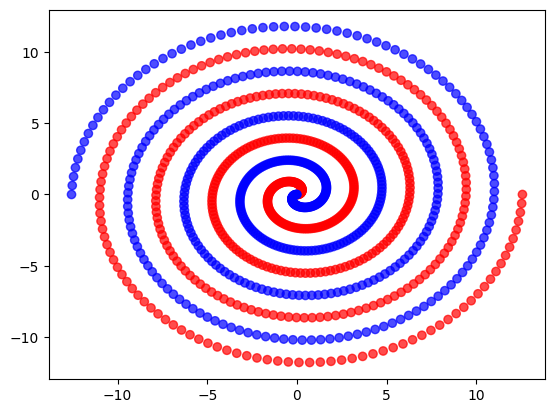

In [90]:
np.random.seed(42)
points, labels = dim_spirals_noisy_features(500, 4, 4, 0.0)
# print(points)
colors = ['red' if label == 'A' else 'blue' for label in labels]
plt.scatter(points[:, 2], points[:, 3], c=colors, cmap='coolwarm', alpha=0.7)
plt.show()

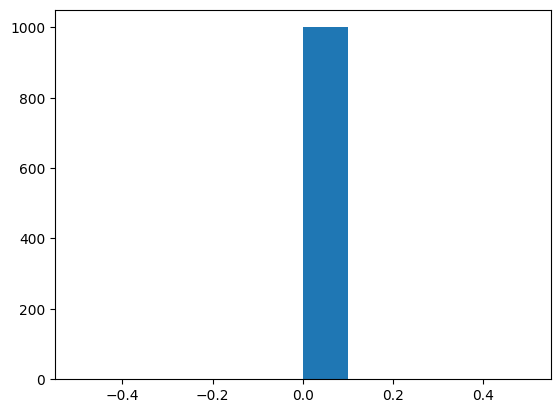

In [91]:
plt.hist(points[:, 4])
plt.show()

In [92]:
nf_accuracies = pd.DataFrame(
    {
        'Seed': seeds,
        'Metric': metric_res,
        'KernelMix': mix_res,
        'ExtraTrees': et_res,
        'KNN': knn_res
    }
)
print(nf_accuracies.head())
nf_accuracies.to_csv(f'nf_accuracies_{time.time_ns()}_nest{n_estimators}_ts{test_size}_t{times}_dev{std_dev}.csv')

         Seed   Metric  KernelMix  ExtraTrees      KNN
0  2291684824  0.54250     0.6700     0.54500  0.66000
1  2601502636  0.57375     0.7325     0.58125  0.71125
2   705051348  0.55500     0.6750     0.53625  0.67125
3  3850542460  0.54250     0.6875     0.53875  0.67375
4  1554066772  0.55625     0.6550     0.53375  0.65125
